In [17]:
from pyspark.sql.functions import mean, udf, col
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

## import csv files into spark dataframes
Note: both files contain records from all 5 boroughs

In [2]:
df1 = spark.read.csv('data/pluto_18v11.csv', header=True)
df2 = spark.read.csv('data/pluto_18v1.csv', header=True)

## Change column names and joining dataframes
* since we are doing column comparison, we need to the column names of one df to avoid confusion
* in this case, we add "_1"_ to the name, e.g. "BBL" ==> "BBL_1"
* here we are doing an inner join because we only care about the BBL's that apeared in both dataframes

In [3]:
df1 = df1.select([col(A).alias(A+'_1') for A in df1.schema.names])

In [4]:
df1_names = df1.schema.names
df2_names = df2.schema.names
colnames = zip(df1_names, df2_names)

In [5]:
df = df2.join(df1, df2['BBL'] == df1['bbl_1'])

## Create UDF (user defined function) for column comparison
* by doing ```@udf``` decorator, we are basically telling spark to optimize this function for column wise paralellized operations (it's a black box to me) 

In [6]:
@udf
def compare(col1,col2):
    if col1!=col2:
        return 1
    else:
        return 0

## Generate results
1. generate the mismatch dummy column 
2. get rid of the original valued columns
3. calculate the mean (in this case represents the percentage of mismatches) and produce output

In [7]:
spark.sql('set spark.sql.caseSensitive=true')
for A,B in colnames:
    df = df.withColumn(A+'%', compare(col(A),col(B)))\
               .drop(A,B)
results = df.select(*[mean(col(A)).alias(A) for A in df.schema.names])

## Convert spark dataframe to pandas dataframe 
so we can easily export as a csv or conduct further analysis/visualizations

In [8]:
start_time = time.time()
results_df = results.toPandas()
elapsed_time = time.time() - start_time

In [9]:
results_df

,borough_1%,block_1%,lot_1%,cd_1%,ct2010_1%,cb2010_1%,schooldist_1%,council_1%,zipcode_1%,firecomp_1%,...,zmcode_1%,sanborn_1%,taxmap_1%,edesignum_1%,appbbl_1%,appdate_1%,plutomapid_1%,firm07_flag_1%,pfirm15_flag_1%,version_1%
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
elapsed_time

141.2375509738922

In [16]:
results_df.iloc[0,:].sort_values(ascending=False)[0:30]

version_1%       1.000000
zonemap_1%       0.999770
splitzone_1%     0.194827
zonedist2_1%     0.022012
landuse_1%       0.008952
spdist1_1%       0.008866
zonedist1_1%     0.008613
facilfar_1%      0.008480
residfar_1%      0.008418
commfar_1%       0.007839
overlay1_1%      0.007523
zmcode_1%        0.000867
zonedist3_1%     0.000383
overlay2_1%      0.000180
ltdheight_1%     0.000086
spdist2_1%       0.000074
zonedist4_1%     0.000027
spdist3_1%       0.000001
ownername_1%     0.000000
lotarea_1%       0.000000
bldgarea_1%      0.000000
ownertype_1%     0.000000
easements_1%     0.000000
block_1%         0.000000
bldgclass_1%     0.000000
lot_1%           0.000000
comarea_1%       0.000000
resarea_1%       0.000000
officearea_1%    0.000000
retailarea_1%    0.000000
Name: 0, dtype: float64

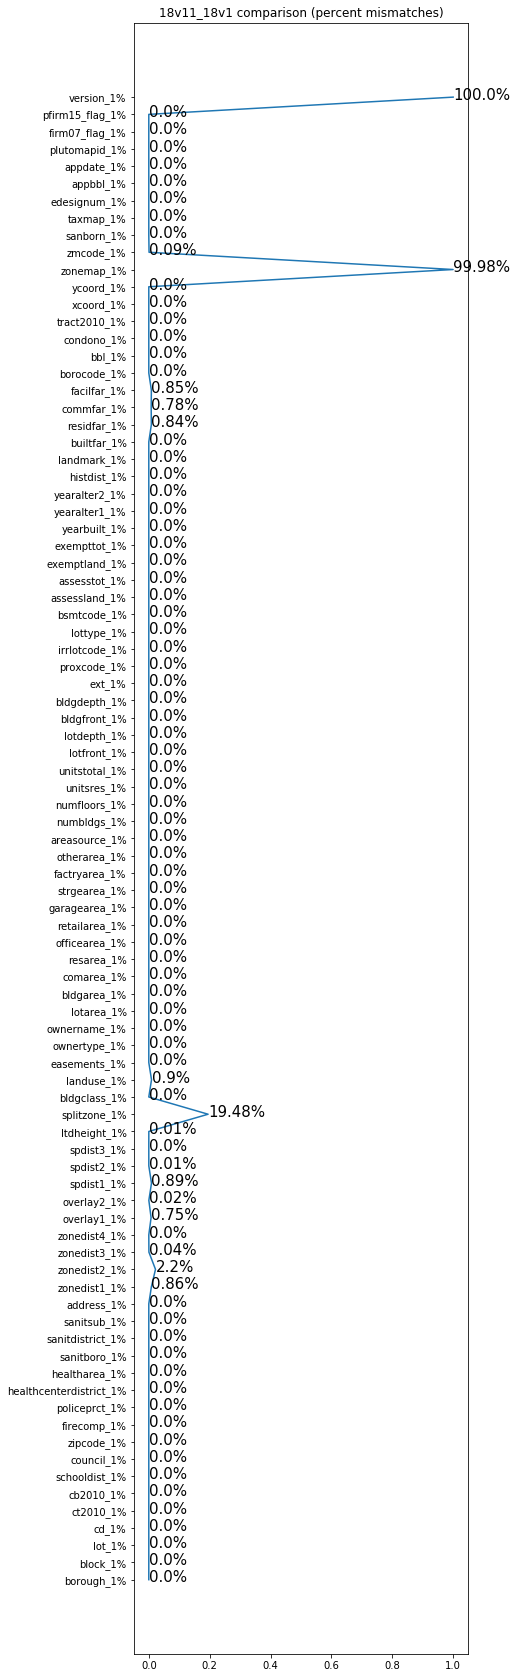

In [20]:
plt.figure(figsize=(6, 30))
plt.plot(results_df.iloc[0, :], range(87))
label = list(results_df.iloc[0, :])
for i in range(len(label)):
    plt.text(x = label[i] , y = i-0.15, s = '{}%'.format(round(label[i]*100, 2)), size = 15)
plt.yticks(range(87), results_df.columns, rotation='horizontal')
plt.title('18v11_18v1 comparison (percent mismatches)')
plt.show()